# RAMOSE log analysis


In [1]:
import pandas as pd
import zipfile , csv , re

Load data from zip file to a dataframe

In [2]:
zf1 = zipfile.ZipFile('log-2018-0212-filtered.csv.zip')
df1 = pd.read_csv(zf1.open('log-2018-0212-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf2 = zipfile.ZipFile('log-2019-0112-filtered.csv.zip')
df2 = pd.read_csv(zf2.open('log-2019-0112-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf3 = zipfile.ZipFile('log-2020-0102-filtered.csv.zip')
df3 = pd.read_csv(zf3.open('log-2020-0102-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)

zf4 = zipfile.ZipFile('log-2020-0105-filtered.csv.zip')
df4 = pd.read_csv(zf4.open('log-2020-0105-filtered.csv'), sep=',', error_bad_lines=False, quoting=csv.QUOTE_NONE, warn_bad_lines=False)
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.head()

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI
0,"453""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/
1,"244""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/,130.136.130.1,/about
2,"689""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/about,130.136.130.1,/corpus
3,"245""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://130.136.130.1/corpus,130.136.130.1,/model
4,"424""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/corpus/br/1.html


In [3]:
print(len(df))

41106724


## Pruning and cleansing

Prune all sparql queries that start from a search text

In [4]:
df_sparql = df[(df['REQUEST_URI'].str.match('^/sparql\?query.*')== True) & (df["HTTP_REFERER"].str.contains('search.*')==False)]

In [5]:
print(len(df_sparql))

1652299


In [6]:
from urllib.parse import unquote
def clean_query(query):
    # unescape query
    q = unquote(query).replace('+',' ')
    # remove prefixes
    q1 = re.sub('\/sparql\?query', '', q, flags=re.IGNORECASE | re.S | re.DOTALL) # does not work
    q2 = re.sub('(prefix.*<.*?>).*select', '', q1, flags=re.IGNORECASE | re.S | re.DOTALL) 
    q2_1 = re.sub('(\&format\=json)|(output\=json)|(results\=json)','',q2, flags=re.IGNORECASE) # &output=json&results=json
    # normalise variables
    q3 = re.sub('(\?\w+)', '?v', q2_1)
    # normalise URIs
    q4 = re.sub('(<.*>)','<uri>', q3)
    # normalise strings
    q5 = re.sub('(\".*\")','"string"',q4)
    q6 = re.sub('(\'.*\')','"string"',q5)
    q7 = re.sub('\n','',q6)
    q8 = re.sub('\s+','',q7)
    q9 = re.sub('(limit\d+)','',q8, flags=re.IGNORECASE)
    q10 = re.sub('(offset\d+)','',q9, flags=re.IGNORECASE)
    return q10

def match_tail_queries(query):
    # match queries with less than 4 query variables
    variables = query.split("{", 1)[0]
    return 'tail query' if variables.count('?') < 4 else query

Clean the queries (add a new column to the dataframe) and label those that have less than 4 query variables.

In [7]:
df_sparql['CLEAN_QUERY'] = df_sparql['REQUEST_URI']
df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(clean_query)
df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(match_tail_queries)
df_sparql.head()
# print(df_sparql.iloc[1,5])

<ipython-input-7-081b1f131f9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sparql['CLEAN_QUERY'] = df_sparql['REQUEST_URI']
<ipython-input-7-081b1f131f9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sparql['CLEAN_QUERY'] = df_sparql['CLEAN_QUERY'].apply(clean_query)
<ipython-input-7-081b1f131f9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI,CLEAN_QUERY
22,"904""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,None,130.136.130.1,/sparql?query=select%20distinct%20?scheme%20{%...,tail query
193,"379""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
194,"025""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,tail query
197,"132""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,tail query
374,"074""",85.0.40.84,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...


In [8]:
print(len(df_sparql))

1652299


Prune queries that have less than 4 query variables.

In [9]:
# prune queries that have < 4 query variables
df_sparql_no_tail = df_sparql[df_sparql['CLEAN_QUERY'].str.match('tail query')== False]
df_sparql_no_tail.head(10)

,TIME,REMOTE_ADDR,HTTP_USER_AGENT,HTTP_REFERER,HTTP_HOST,REQUEST_URI,CLEAN_QUERY
193,"379""",2.42.3.29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
374,"074""",85.0.40.84,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
582,"169""",46.135.89.242,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:58....,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
2969,"276""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
2970,"158""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
2971,"041""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
2973,"882""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
2975,"721""",82.217.102.220,Mozilla/5.0 (Android 7.1.2; Mobile; rv:58.0) G...,http://opencitations.net/sparql,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A%2F%2Fp...,=?v?v?v?vWHERE{<uri>cito:cites?v.OPTIONAL{<uri...
2976,"501""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...
2977,"132""",137.204.150.12,sparqlwrapper 1.8.0 (rdflib.github.io/sparqlwr...,None,opencitations.net,/sparql?query=PREFIX+cito%3A+%3Chttp%3A//purl....,=?v?v?v?vWHERE{BIND(<uri>AS?v)?vcito:cites?v.O...


In [10]:
print(len(df_sparql_no_tail))

60040


Prune queries that have been performed less than 10 times.

In [11]:
queries = df_sparql_no_tail['CLEAN_QUERY'].tolist()
from collections import Counter
counter_queries = Counter(queries).most_common()

# queries > 10 times
queries_10_min = {q:c for q,c in counter_queries if c >= 10}
size_queries = 0
types_queries = len(queries_10_min)
for q,c in queries_10_min.items():
    size_queries += c
    
# queries < 10 times
queries_outliers = {q:c for q,c in counter_queries if c < 10}
size_outliers = 0
types_outliers = len(queries_outliers)
for q,c in queries_outliers.items():
    size_outliers += c

print(types_queries, 'queries performed more than 10 times (',size_queries,'total queries)' )    
print(types_outliers, 'queries performed less than 10 times (',size_outliers, 'total times)')

72 queries performed more than 10 times ( 59647 total queries)
162 queries performed less than 10 times ( 393 total times)


## Match with API calls
Here below the 5 SPARQL queries performed by OC APIs

In [12]:
metadata = """PREFIX cito: <http://purl.org/spar/cito/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX frbr: <http://purl.org/vocab/frbr/core#>
PREFIX datacite: <http://purl.org/spar/datacite/>
PREFIX literal: <http://www.essepuntato.it/2010/06/literalreification/>
PREFIX pro: <http://purl.org/spar/pro/>
PREFIX oco: <https://w3id.org/oc/ontology/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX prism: <http://prismstandard.org/namespaces/basic/2.0/>

SELECT DISTINCT ?occ_id ?author ?year ?title ?source_title ?volume ?issue ?page ?doi ?occ_reference ?doi_reference ?citation_count
WHERE {
    VALUES ?doi { "string" } 
    ?article a fabio:Expression ; 
        datacite:hasIdentifier [datacite:usesIdentifierScheme datacite:doi ; literal:hasLiteralValue ?doi] .
    BIND (STRAFTER(str(?article), "https://w3id.org/oc/corpus/") as ?occ_id)
    { SELECT DISTINCT ?article (GROUP_CONCAT(?cited_occ_id; separator="; ") as ?occ_reference) (GROUP_CONCAT(?cited_doi; separator="; ") as ?doi_reference) 
    {
      VALUES ?doi { [["string"]] } 
      ?article a fabio:Expression ;
          datacite:hasIdentifier [ datacite:usesIdentifierScheme datacite:doi ; literal:hasLiteralValue ?doi ] .
        OPTIONAL {
            ?article cito:cites ?cited .
            BIND(STRAFTER(str(?cited), "https://w3id.org/oc/corpus/") as ?cited_occ_id)
            OPTIONAL {
                ?cited datacite:hasIdentifier [
                    datacite:usesIdentifierScheme datacite:doi ;
                    literal:hasLiteralValue ?cited_doi
                ] .
                FILTER(!STRSTARTS(?cited_doi, "http") && !STRENDS(?cited_doi, ".") && !STRENDS(?cited_doi, "("))
                }
            }
        } GROUP BY ?article
    }
    {
        SELECT ?article ?doi (count(?doi) as ?citation_count) {
			VALUES ?doi { [[dois]] }

			?article a fabio:Expression ;
                datacite:hasIdentifier [
                    datacite:usesIdentifierScheme datacite:doi ;
                    literal:hasLiteralValue ?doi
                ] .

			OPTIONAL { ?article ^cito:cites ?other }
		} GROUP BY ?article ?doi
	}

	{
		SELECT ?article ?doi (GROUP_CONCAT(?a; separator="; ") as ?author) {
			VALUES ?doi { [[dois]] }

			{
			SELECT ?article ?doi ?a (count(?next) as ?tot) {
				VALUES ?doi { [[dois]] }

				?article a fabio:Expression ;
					datacite:hasIdentifier [
						datacite:usesIdentifierScheme datacite:doi ;
						literal:hasLiteralValue ?doi
					] .

				OPTIONAL {
					?article pro:isDocumentContextFor ?role .
					?role pro:withRole pro:author ; pro:isHeldBy [
						foaf:familyName ?f_name ;
						foaf:givenName ?g_name
					] .
					OPTIONAL { ?role oco:hasNext* ?next }
					BIND(CONCAT(?f_name, ", ",?g_name) as ?a)
				}
			} GROUP BY ?article ?doi ?a ORDER BY DESC(?tot)}
		} GROUP BY ?article ?doi
	}

	OPTIONAL { ?article ^cito:cites ?other }
	OPTIONAL { ?article dcterms:title ?title }
	OPTIONAL { ?article fabio:hasPublicationYear ?year }
	OPTIONAL {
		?article frbr:partOf+ ?source .
		FILTER NOT EXISTS {
			?source frbr:partOf ?another_source
		}
		?source dcterms:title ?source_title
	}
	OPTIONAL {
		?article frbr:partOf+ ?v .
		?v a fabio:JournalVolume ;
			fabio:hasSequenceIdentifier ?volume
	}
	OPTIONAL {
		?article frbr:partOf+ ?i .
		?i a fabio:JournalIssue ;
			fabio:hasSequenceIdentifier ?issue
	}
	OPTIONAL {
		?article frbr:embodiment ?man .
		?man prism:startingPage ?start .
		OPTIONAL { ?man prism:endingPage ?end }
		BIND (CONCAT(?start, IF(bound(?end), CONCAT("-", ?end), "")) as ?page)
	}
}
LIMIT 10000"""

coauthorship = """PREFIX fabio: <http://purl.org/spar/fabio/>
PREFIX datacite: <http://purl.org/spar/datacite/>
PREFIX literal: <http://www.essepuntato.it/2010/06/literalreification/>
PREFIX pro: <http://purl.org/spar/pro/>
PREFIX oco: <https://w3id.org/oc/ontology/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?author1 ?author2 (count(?author1) as ?coauthorship_count) WHERE {
	VALUES ?doi { [[dois]] }

	?article a fabio:Expression ;
		datacite:hasIdentifier [
			datacite:usesIdentifierScheme datacite:doi ;
			literal:hasLiteralValue ?doi
		] ;

		pro:isDocumentContextFor ?auth1 , ?auth2 .

		?auth1 oco:hasNext+ ?auth2 .

		?auth1 pro:isHeldBy [
			foaf:givenName ?gn1 ;
			foaf:familyName ?fn1
		] .
		?auth2 pro:isHeldBy [
			foaf:givenName ?gn2 ;
			foaf:familyName ?fn2
		] .

	BIND (CONCAT(?fn1, ", ", ?gn1) as ?author1) .
	BIND (CONCAT(?fn2, ", ", ?gn2) as ?author2) .
}
GROUP BY ?author1 ?author2
LIMIT 10000"""

references = """PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<http://dx.doi.org/[[doi]]> as ?citing_iri) .
        ?citing_iri ^cito:hasCitingEntity ?oci_iri .
        ?oci_iri
            cito:hasCitedEntity ?cited_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

citations = """PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<http://dx.doi.org/[[doi]]> as ?cited_iri) .
        ?cited_iri ^cito:hasCitedEntity ?oci_iri .
        ?oci_iri
            cito:hasCitingEntity ?citing_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

citation = """
PREFIX cito: <http://purl.org/spar/cito/>
SELECT ?oci ?citing ?cited ?creation ?timespan (IF(bound(?jsc), "yes", "no") as ?journal_sc) (IF(bound(?asc), "yes", "no") as ?author_sc)
WHERE {
    GRAPH <https://w3id.org/oc/index/coci/> {
        BIND(<https://w3id.org/oc/index/coci/ci/[[oci]]> as ?oci_iri) .
        ?oci_iri
            cito:hasCitingEntity ?citing_iri ;
            cito:hasCitedEntity ?cited_iri ;
            cito:hasCitationCreationDate ?creation ;
            cito:hasCitationTimeSpan ?timespan .

        OPTIONAL {
            ?oci_iri a cito:JournalSelfCitation .
            BIND("yes" as ?jsc)
        }

        OPTIONAL {
            ?oci_iri a cito:AuthorSelfCitation .
            BIND("yes" as ?asc)
        }

        BIND(STRAFTER(str(?citing_iri), "http://dx.doi.org/") AS ?citing)
        BIND(STRAFTER(str(?cited_iri), "http://dx.doi.org/") AS ?cited)
        BIND(STRAFTER(str(?oci_iri), "/ci/") AS ?oci)
    }
}
LIMIT 10000"""

metadata_clean = clean_query(metadata)
references_clean = clean_query(references)
citations_clean = clean_query(citations)
citation_clean = clean_query(citation)
coauthorship_clean = clean_query(coauthorship)
api_calls = [metadata_clean, references_clean, citations_clean, citation_clean, coauthorship_clean]
api_names = ['metadata_clean', 'references_clean', 'citations_clean', 'citation_clean', 'coauthorship_clean']

Cluster SPARQL queries by affinity propagation.

In [13]:
import distance
import numpy as np
from sklearn.cluster import AffinityPropagation
queries_10_min_list = [q for q,c in queries_10_min.items()]
queries_10_min_list = np.asarray(queries_10_min_list)
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in queries_10_min_list] for w2 in queries_10_min_list])

# affinity propagation for clustering 
# Reference: Brendan J. Frey and Delbert Dueck, “Clustering by Passing Messages Between Data Points”, Science Feb. 2007
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = queries_10_min_list[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(queries_10_min_list[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = "\n ".join(cluster)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


## Plotting clusters

Processed 10/72 rows of api call
Processed 20/72 rows of api call
Processed 30/72 rows of api call
Processed 40/72 rows of api call
Processed 50/72 rows of api call
Processed 60/72 rows of api call
Processed 70/72 rows of api call


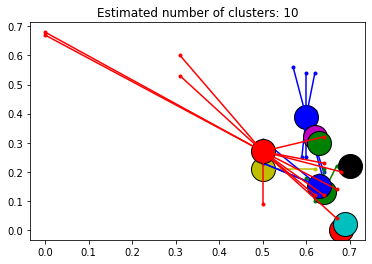

In [14]:
# Plot results
import matplotlib.pyplot as plt
from itertools import cycle
from fuzzywuzzy import fuzz

plt.close('all')
plt.figure(1)
plt.clf()

def compute_similarity(s1, s2):
    return 1.0 - (0.01 * max(
        fuzz.ratio(s1, s2),
        fuzz.partial_ratio(s1, s2),
        fuzz.token_set_ratio(s1, s2)))

X = np.zeros((len(queries_10_min_list), len(queries_10_min_list)))
for i in range(len(queries_10_min_list)):
    if i > 0 and i % 10 == 0:
        print("Processed %d/%d rows of api call" % (i, X.shape[0]))
    for j in range(len(queries_10_min_list)):
        if X[i, j] == 0.0:        
            X[i, j] = compute_similarity(queries_10_min_list[i].lower(), queries_10_min_list[j].lower())
            X[j, i] = X[i, j]

n_clusters_ = len(affprop.cluster_centers_indices_)
cluster_centers_indices = affprop.cluster_centers_indices_
labels = affprop.labels_

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=24)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Match to API calls

Exemplars in clusters are matched against SPARQL queries performed by the APIs. The similarity is calculated by using  Levenshtein Distance between the query strings.

overview:


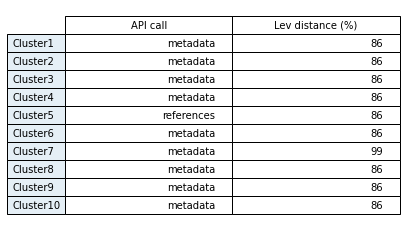

In [19]:
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

print("overview:" )
i = 0
cell_text , row_headers = [] , []
for cluster_id in np.unique(affprop.labels_):
    exemplar = queries_10_min_list[affprop.cluster_centers_indices_[cluster_id]]
    original_q = unquote(df_sparql_no_tail.loc[df_sparql_no_tail['CLEAN_QUERY'] == exemplar, 'REQUEST_URI'].iloc[0]).replace('+',' ')
    i+=1
    best_match = process.extractOne(exemplar,api_calls)
    index = api_calls.index(best_match[0])
    name = api_names[index].replace('_clean','')  
    row_headers.append('Cluster'+str(i))
    cell_text.append([name, best_match[1]])

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
column_headers = ['API call', 'Lev distance (%)'] #  -partial ratio
the_table = plt.table(cellText=cell_text,
                  rowLabels=row_headers,
                  rowColours=rcolors,
                  colLabels=column_headers,
                  loc='center')

the_table.scale(1, 1.5)


#### TODO: 

 * where to upload data, if relevant
 * double-check queries, some look like oscar queries (look at rows around the one with the query)
 * should we prune also queries that are repeated too many times (e.g. thousands of times)?
 * should I look at how many queries correspond to an exemplar? so that we have an idea to how many queries we cover with an API call?